In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery, MultiWindowQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from dotenv import load_dotenv

In [4]:
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'
# casp_protein_ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
# pdb_codes = ['6T1Z', '7UM1', '7D2O', '7CN6', '7W6B', '7ABW', '6Y4F', '6POO', '6YJ1', '6YA2', '6UV6', '6VQP']
pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if len(list(f.iterdir())) == 5]
winsizes = [4,5,6,7]
lengths = [6000, 500, 50, 15]
lengths_dict = {w:l for w,l in zip(winsizes, lengths)}

das = {}
seqs = []
for id in pdb_codes:
    da = MultiWindowQuery(id, winsizes, PDBMINE_URL, PROJECT_DIR)
    da.load_results()
    seqs.append(pd.DataFrame(da.xray_phi_psi.seq_ctxt.unique(), columns=['seq']))
    seqs[-1]['id'] = id
    das[id] = da

seq_matches = []
seqs = pd.concat(seqs)
seqs = seqs[~seqs.seq.str.contains('X')]
print(seqs.shape, seqs.seq.nunique())
n_matches = defaultdict(list)
X = []
y = []
for i,row in tqdm(seqs.iterrows()):
    phis = []
    psis = []
    xray_phi = das[row.id].xray_phi_psi[das[row.id].xray_phi_psi.seq_ctxt == row.seq].phi.values[0]
    xray_psi = das[row.id].xray_phi_psi[das[row.id].xray_phi_psi.seq_ctxt == row.seq].psi.values[0]
    if np.isnan(xray_phi) or np.isnan(xray_psi):
        for w in winsizes:
            n_matches[w].append(0)
        continue
    for q in das[row.id].queries:
        inner_seq = q.get_subseq(row.seq)
        matches = q.results[q.results.seq == inner_seq][['seq', 'phi', 'psi']]
        n_matches[q.winsize].append(matches.shape[0])
        if matches.shape[0] == 0:
            phis.append(np.zeros(lengths_dict[q.winsize]))
            psis.append(np.zeros(lengths_dict[q.winsize]))
            continue
        phi = matches.phi.values
        psi = matches.psi.values
        if matches.shape[0] >= lengths_dict[q.winsize]:
            phi = np.random.choice(phi, lengths_dict[q.winsize], replace=False)
            psi = np.random.choice(psi, lengths_dict[q.winsize], replace=False)
        else:
            phi = np.pad(phi, (0, lengths_dict[q.winsize] - matches.shape[0]))
            psi = np.pad(psi, (0, lengths_dict[q.winsize] - matches.shape[0]))
        phis.append(phi)
        psis.append(psi)
    if len(phis) == 0:
        continue
    phis = np.concatenate(phis)
    psis = np.concatenate(psis)

    X.append(np.stack([phis, psis]))
    y.append(np.array([xray_phi, xray_psi]))
all_X = np.stack(X)
all_y = np.stack(y)
for k,v in n_matches.items():
    seqs[k] = v
seqs.describe()

Results already exist
Structure exists: 'pdb/pdb5b3k.ent' 
Results already exist
Structure exists: 'pdb/pdb6vqp.ent' 
Results already exist
Structure exists: 'pdb/pdb5sj7.ent' 
Results already exist
Structure exists: 'pdb/pdb3imc.ent' 
Results already exist
Structure exists: 'pdb/pdb6alv.ent' 
Results already exist
Structure exists: 'pdb/pdb7ooe.ent' 
Results already exist
Structure exists: 'pdb/pdb6em9.ent' 
Results already exist
Structure exists: 'pdb/pdb6t1z.ent' 
Results already exist
Structure exists: 'pdb/pdb2q14.ent' 
Results already exist
Structure exists: 'pdb/pdb7d2o.ent' 
Results already exist
Structure exists: 'pdb/pdb1a71.ent' 
Results already exist
Structure exists: 'pdb/pdb7w6b.ent' 
Results already exist
Structure exists: 'pdb/pdb6poo.ent' 
Results already exist
Structure exists: 'pdb/pdb7o8m.ent' 
Results already exist
Structure exists: 'pdb/pdb4wdb.ent' 
Results already exist
Structure exists: 'pdb/pdb6y4f.ent' 
Results already exist
Structure exists: 'pdb/pdb6yj1.ent

7128it [04:45, 25.01it/s] 


,4,5,6,7
count,7128.000000,7128.000000,7128.000000,7128.000000
mean,2461.491021,235.978535,88.873457,77.520062
std,2021.800954,350.163191,237.800750,233.959455
min,0.000000,0.000000,0.000000,0.000000
25%,1032.000000,46.000000,2.000000,0.000000
50%,1923.500000,119.000000,10.000000,3.000000
75%,3307.000000,278.250000,52.000000,36.000000
max,17774.000000,6201.000000,1723.000000,1354.000000


In [29]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

torch.Size([5670, 2, 6565]) torch.Size([5670, 2]) torch.Size([1418, 2, 6565]) torch.Size([1418, 2])


In [31]:
torch.save(all_X, 'ml_data/all_X.pt')
torch.save(all_y, 'ml_data/all_y.pt')

In [ ]:
all_X = torch.load('ml_data/all_X.pt')
all_y = torch.load('ml_data/all_y.pt')

In [32]:
X,y = next(iter(trainloader))

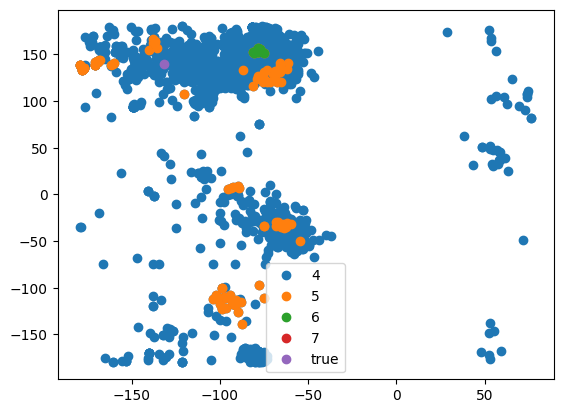

In [35]:
def plot(Xp, y, i, logits=None):
    ls = lengths
    Xp = Xp.cpu().clone().detach()
    y = y.cpu().clone().detach()
    Xp[Xp==0] = np.nan
    s = [sum(lengths[:i]) for i,l in enumerate(ls)]
    s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
    plt.plot(Xp[i, 0, s[0]:s[1]], Xp[i, 1, s[0]:s[1]], 'o', label='4')
    plt.plot(Xp[i, 0, s[1]:s[2]], Xp[i, 1, s[1]:s[2]], 'o', label='5')
    plt.plot(Xp[i, 0, s[2]:s[3]], Xp[i, 1, s[2]:s[3]], 'o', label='6')
    plt.plot(Xp[i, 0, s[3]:    ], Xp[i, 1, s[3]:    ], 'o', label='7')
    
    plt.plot(y[i,0],y[i,1], 'o', label='true')
    if logits is not None:
        logits = logits.cpu().clone().detach()
        plt.plot(logits[i,0].detach(),logits[i,1].detach(), 'o', label='pred')
    plt.legend()
plot(X,y,1)

In [100]:
length = sum([l*2 for l in lengths])
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(length, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = Net().to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [128]:
length = sum([l for l in lengths])
s = [sum(lengths[:i]) for i,l in enumerate(lengths)]

class SparseNet(torch.nn.Module):
    def __init__(self):
        super(SparseNet, self).__init__()
        self.dropout = nn.Dropout(0.25)

        self.phi1 = nn.Linear(lengths[0], 1)
        self.psi1 = nn.Linear(lengths[0], 1)
        self.phi2 = nn.Linear(lengths[1], 1)
        self.psi2 = nn.Linear(lengths[1], 1)
        self.phi3 = nn.Linear(lengths[2], 1)
        self.psi3 = nn.Linear(lengths[2], 1)
        self.phi4 = nn.Linear(lengths[3], 1)
        self.psi4 = nn.Linear(lengths[3], 1)

        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x1 = F.relu(self.dropout(self.phi1(x[:,0,s[0]:s[1]])))
        x2 = F.relu(self.dropout(self.psi1(x[:,1,s[0]:s[1]])))
        x3 = F.relu(self.dropout(self.phi2(x[:,0,s[1]:s[2]])))
        x4 = F.relu(self.dropout(self.psi2(x[:,1,s[1]:s[2]])))
        x5 = F.relu(self.dropout(self.phi3(x[:,0,s[2]:s[3]])))
        x6 = F.relu(self.dropout(self.psi3(x[:,1,s[2]:s[3]])))
        x7 = F.relu(self.dropout(self.phi4(x[:,0,s[3]:])))
        x8 = F.relu(self.dropout(self.psi4(x[:,1,s[3]:])))

        x = torch.cat([x1,x2,x3,x4,x5,x6,x7,x8], dim=1)
        x = F.relu(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        return x
model = SparseNet().to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [247]:
length = sum([l for l in lengths])
s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
device = 'cuda'
class TiedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights1 = nn.Parameter(torch.randn(8,1))
        self.bias1 = nn.Parameter(torch.randn(8))
        self.fc1 = nn.Linear(8, 4096)
        self.fc2 = nn.Linear(4096, 2)
    def forward(self, x):
        x1 = torch.sum(x[:,0,s[0]:s[1]] * self.weights1[0] + self.bias1[0], dim=1).unsqueeze(1)
        x2 = torch.sum(x[:,1,s[0]:s[1]] * self.weights1[1] + self.bias1[1], dim=1).unsqueeze(1)
        x3 = torch.sum(x[:,0,s[1]:s[2]] * self.weights1[2] + self.bias1[2], dim=1).unsqueeze(1)
        x4 = torch.sum(x[:,1,s[1]:s[2]] * self.weights1[3] + self.bias1[3], dim=1).unsqueeze(1)
        x5 = torch.sum(x[:,0,s[2]:s[3]] * self.weights1[4] + self.bias1[4], dim=1).unsqueeze(1)
        x6 = torch.sum(x[:,1,s[2]:s[3]] * self.weights1[5] + self.bias1[5], dim=1).unsqueeze(1)
        x7 = torch.sum(x[:,0,s[3]:] * self.weights1[6] + self.bias1[6], dim=1).unsqueeze(1)
        x8 = torch.sum(x[:,1,s[3]:] * self.weights1[7] + self.bias1[7], dim=1).unsqueeze(1)
        x = torch.hstack([x1,x2,x3,x4,x5,x6,x7,x8])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = TiedNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
sum([p.numel() for p in model.parameters()])

45074

In [36]:
length = sum([l for l in lengths])
s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
device = 'cuda'
class LSTMNet(nn.Module):
    def __init__(self):
        super().__init__()
        h = 256
        nl = 8
        self.lstm1 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=False)
        self.lstm3 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=False)
        self.lstm4 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(h*4, h)
        self.fc2 = nn.Linear(h, 2)
        
    def forward(self, x):
        x1 = x[:,:,s[0]:s[1]].permute(0,2,1)
        x2 = x[:,:,s[1]:s[2]].permute(0,2,1)
        x3 = x[:,:,s[2]:s[3]].permute(0,2,1)
        x4 = x[:,:,s[3]:].permute(0,2,1)
        x1 = self.lstm1(x1)[0][:,-1,:] # last hidden state
        x2 = self.lstm2(x2)[0][:,-1,:]
        x3 = self.lstm3(x3)[0][:,-1,:]
        x4 = self.lstm4(x4)[0][:,-1,:]
        x = torch.cat([x1,x2,x3,x4], dim=1)
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        return x
model = LSTMNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
sum([p.numel() for p in model.parameters()])

16065282

In [37]:
X,y = next(iter(trainloader))
model(X.to(device)).shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 17.21 GiB. GPU 

In [38]:
train_losses = []
test_losses = []
for epoch in (pbar := tqdm(range(500))):
    losses = []
    model.train()
    for X,y in trainloader:
        X,y = X.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    losses = []
    model.eval()
    for X,y in testloader:
        with torch.no_grad():
            X,y = X.to('cuda'), y.to('cuda')
            logits = model(X)
            loss = criterion(logits, y)
            losses.append(loss.item())
    test_losses.append(sum(losses) / len(losses))

    pbar.set_postfix({'train_loss': train_losses[-1], 'test_loss': test_losses[-1]})

  5%|▌         | 26/500 [10:42<3:15:04, 24.69s/it, train_loss=4.88e+3, test_loss=5.04e+3]


KeyboardInterrupt: 

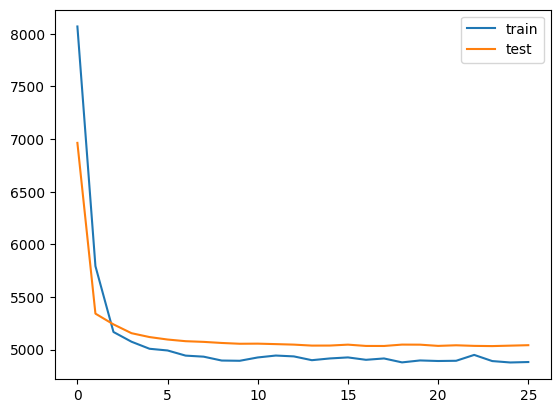

In [39]:
plt.plot(train_losses[:], label='train')
plt.plot(test_losses[:], label='test')
plt.legend()

torch.Size([6000])


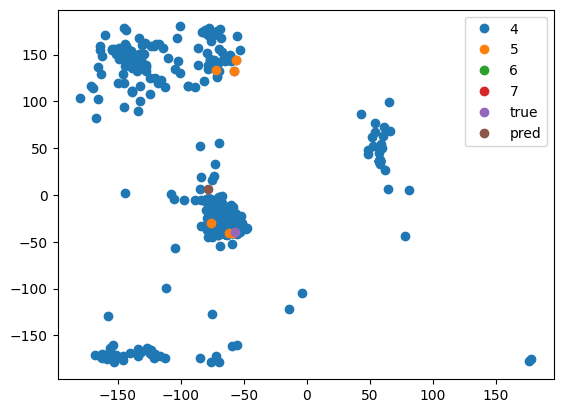

In [328]:
for X,y in testloader:
    with torch.no_grad():
        X,y = X.to('cuda'), y.to('cuda')
        logits = model(X)
    break
plot(X, y, 5, logits)

In [156]:
model.state_dict()['phi1.weight'].shape

torch.Size([1, 6000])

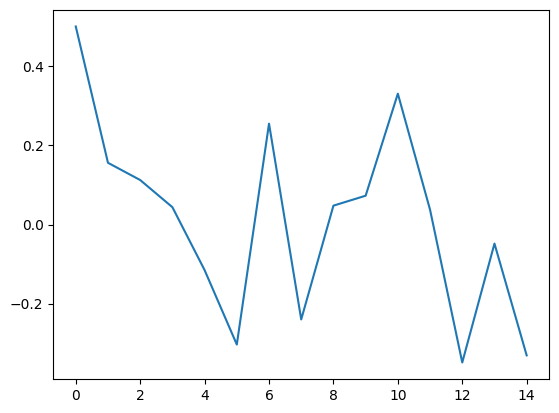

In [164]:
plt.plot(model.state_dict()['psi4.weight'].detach().cpu().numpy().flatten())